**MEDICAL COST PREDICTION**

In [76]:

import pandas as pd
import numpy as np
# visualization tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('fivethirtyeight')
%matplotlib inline
# clustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
# model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

**Data Exploration**

In [77]:
df = pd.read_csv("insurance.csv")
print("Feature data types:")
print(df.dtypes)
df.head(3)

Feature data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [78]:
df.info()
# Check for missing data
print("Number of missing value:", df.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Number of missing value: 0


In [79]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# The mean ($13,270) is significantly higher than the median ($9,382),
# suggesting right skew in our target variable.

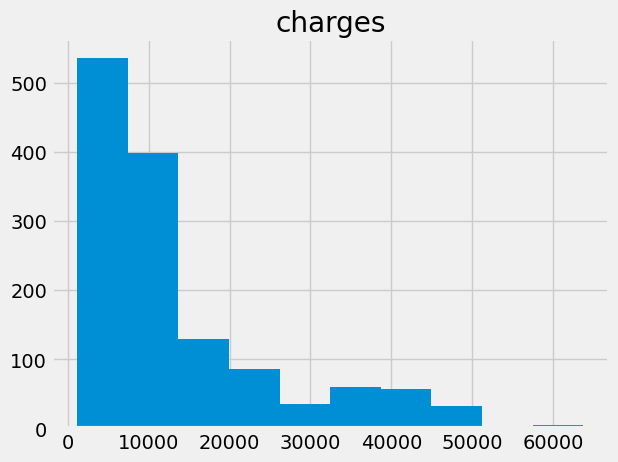

In [80]:
df.hist('charges')
plt.show()

The histogram shows that medical charges are not evenly spread — most values are low, but a few very high bills create a long tail on the right. This means the model's errors might not balance out around zero. Using a log transformation on the target variable could help make the data more suitable for modeling.

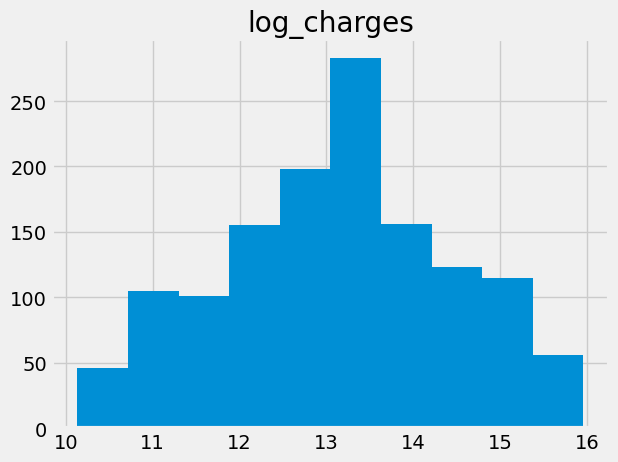

In [81]:
df["log_charges"] = np.log2(df["charges"])

df.hist("log_charges")
plt.show()

Log transforming the charges makes the distribution more normal, which can improve model performance.

In [85]:
# Convert categorical features as dummy variables
df_dummies = pd.get_dummies(df, dtype=int)
# Rearrange response variable to the last column
#   - looks tedious here :-)
y = df_dummies['charges']
df_dummies = df_dummies.drop(columns=['charges'])
df_dummies = pd.concat([df_dummies, y], axis=1)
df_dummies.head(2)

,age,bmi,children,log_charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,27.90,0,14.043448,1,0,0,1,0,0,0,1,16884.9240
1,18,33.77,1,10.752842,0,1,1,0,0,0,1,0,1725.5523


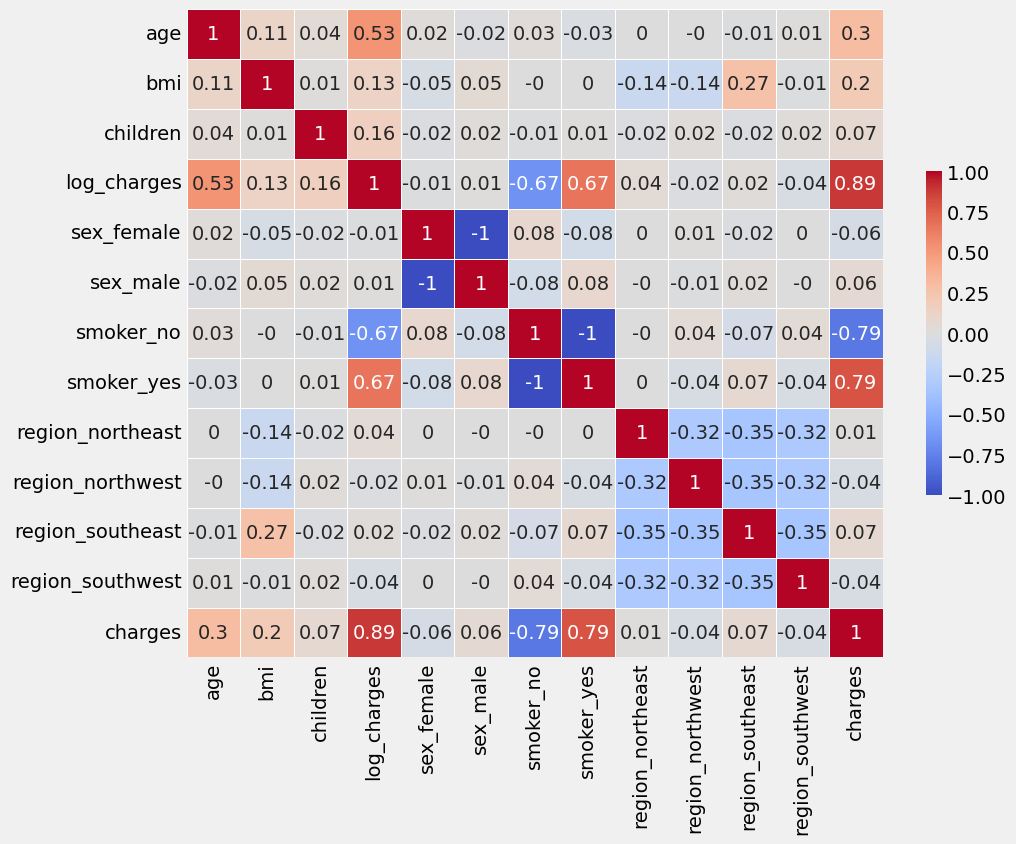

In [86]:
cor = round(df_dummies.corr(), 2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
ax.grid(False)
plt.show()

**Key observations from the correlation matrix:**

Age has a 52.8% correlation with log_charges (much stronger than the 29.9% with raw charges)

BMI shows weaker correlation (13.3% with log_charges)

Children has minimal correlation (16.1% with log_charges)

Looking at the last row of the correlation plot, features like number of children, sex, and region show little to no relationship with the response variable, medical cost. The strongest Pearson correlations are found in the smoker dummy variables, and one of them will be selected for model training. Age and BMI also show moderate correlation with medical cost and will be considered in the model.

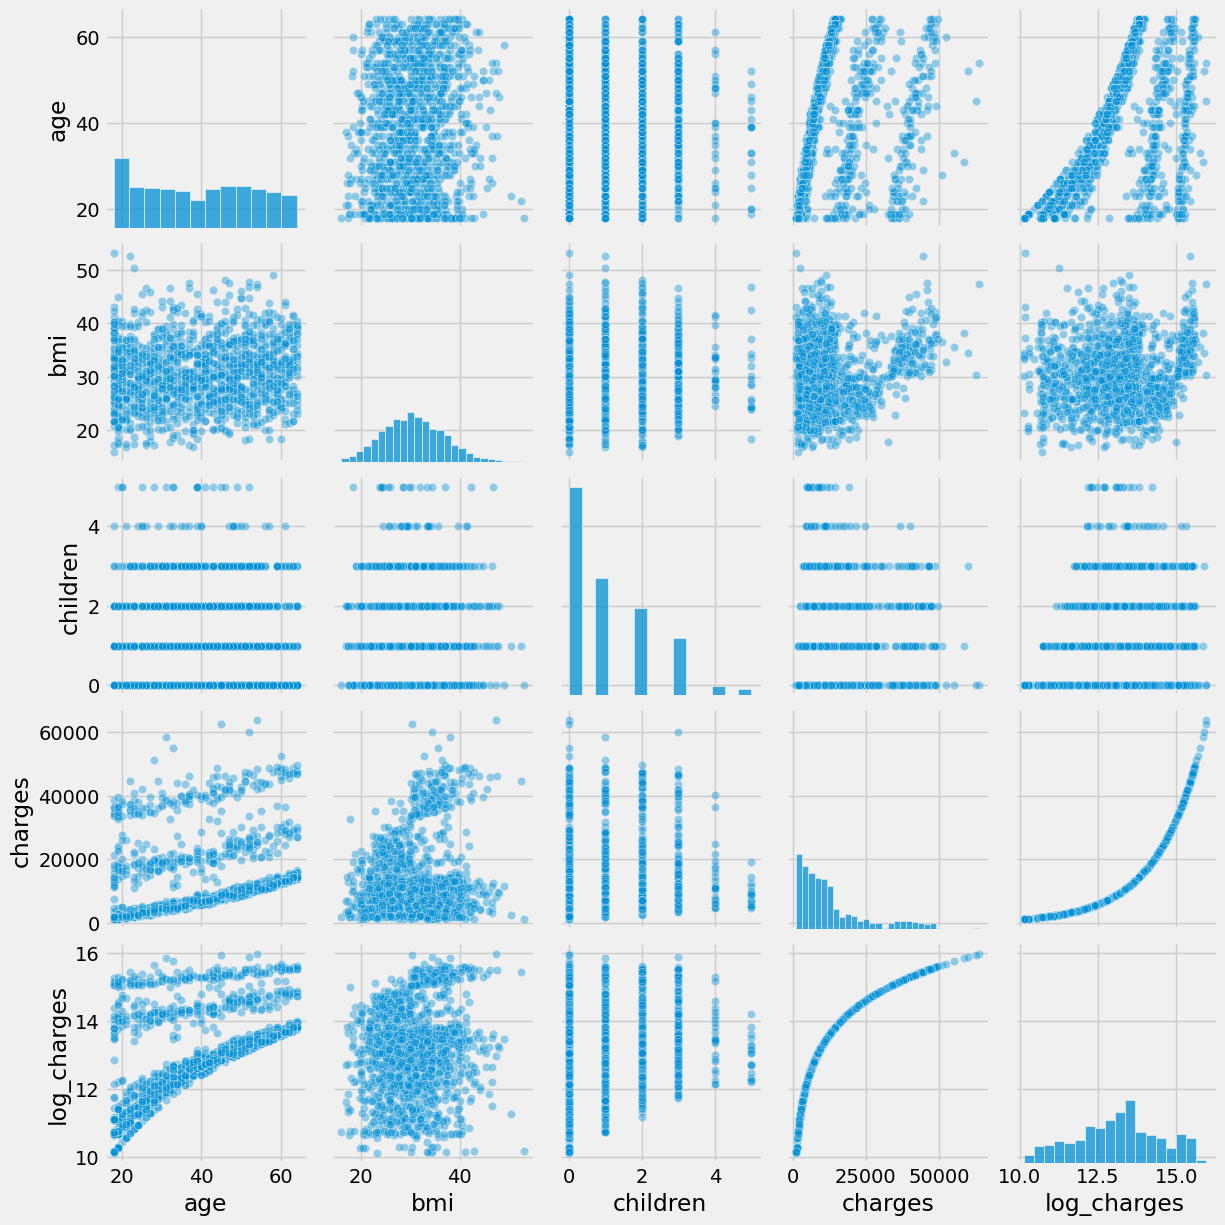

In [83]:
insurance_numeric =df[['age', 'bmi', 'children', 'charges', 'log_charges']]
sns.pairplot(insurance_numeric, kind='scatter', plot_kws={'alpha': 0.4})
plt.show()

The pair plot reveals a clear pattern in the age vs. charges relationship, showing three distinct bands rather than a random scatter. This suggests that the data may not follow a simple linear trend. These clusters likely reflect the influence of an unobserved categorical variable that segments the data into different groups. As such, simple linear regression may not be sufficient, and more advanced techniques such as clustering or including additional categorical features are necessary for more accurate modeling

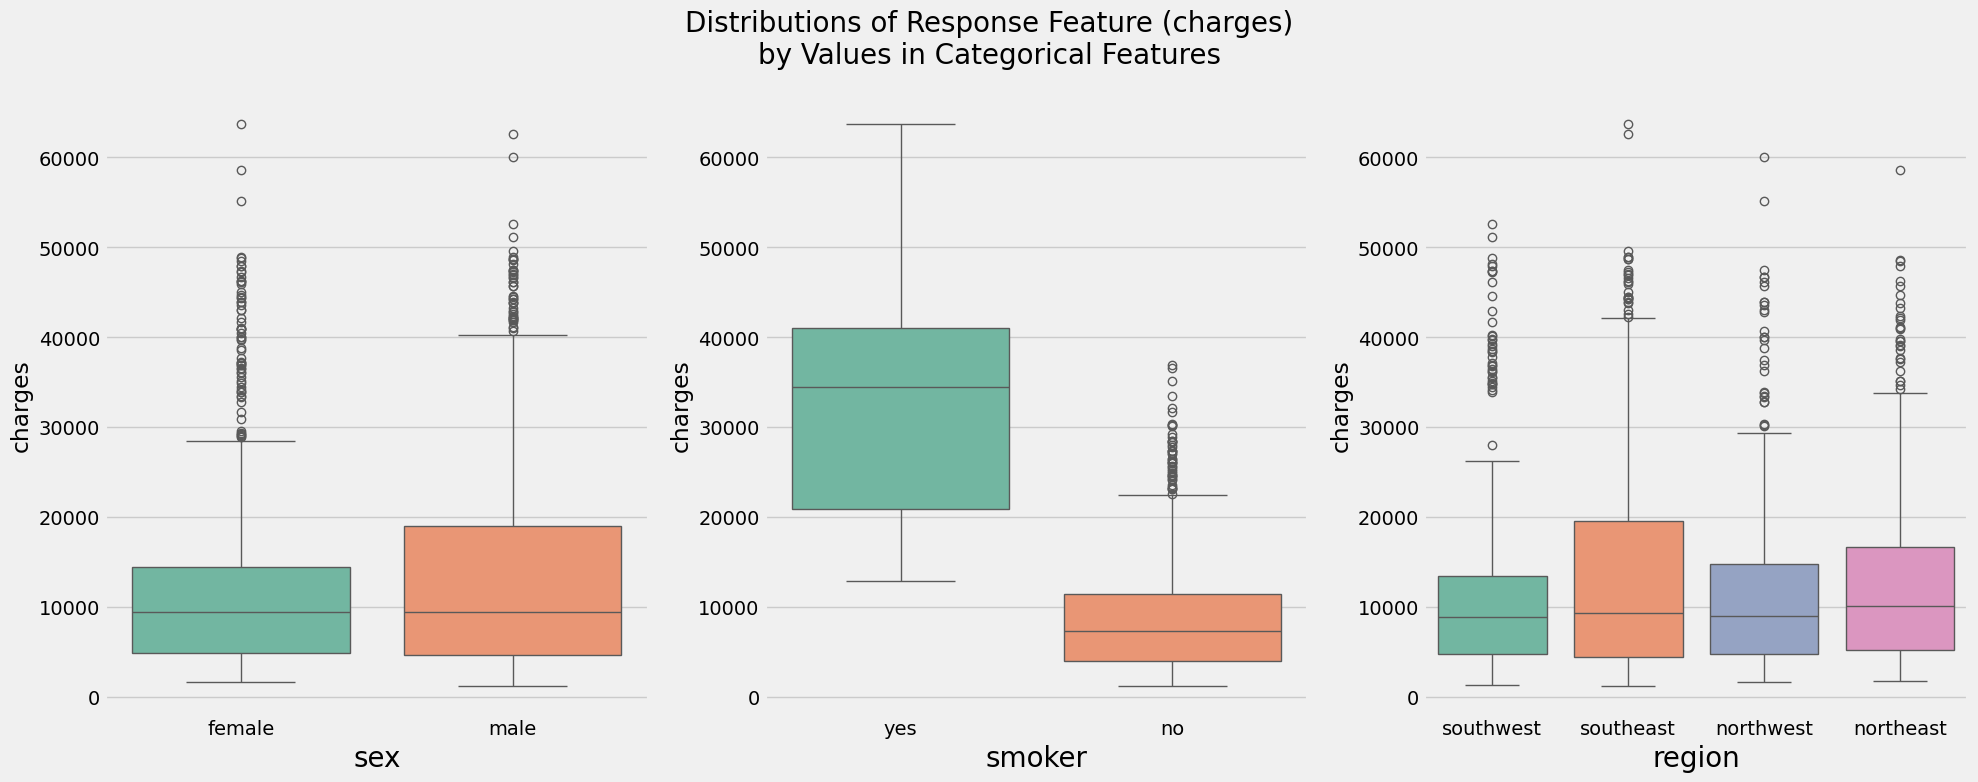

In [56]:
# Boxplots for categorical features
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(df.select_dtypes(include=object).columns):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(df, x=feature, y='charges', hue=feature, palette=sns.color_palette('Set2', n_colors=len(df[feature].value_counts().index)), ax=ax)
    ax.set_xlabel(feature, fontsize=20)
fig.suptitle("Distributions of Response Feature (charges)\nby Values in Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

The box plots reveal the following:

Sex: Males tend to show a wider spread in charges compared to females.

Smoker: Charges for smokers are dramatically higher than for non-smokers, suggesting they may represent two distinct groups.

Region: Regional differences in charges are minimal.

Given the dominant effect of the smoker variable, splitting the data into smoker and non-smoker groups could be beneficial, as each group may follow a different relationship with other predictors. Based on the univariate analysis, age, BMI, and smoker status are positively associated with medical charges and will be included in the final model.



**Dividing the Data**

In [87]:
# Splitting the data up into a training and test set
df["is_smoker"] = (df["smoker"] == "yes")
# df["is_male"] = (df['sex'] == 'male')# df['is_west'] = ((df['region'] == 'northwest') | (df['region'] == 'southwest'))

X = df[["age", "bmi", "is_smoker"]]
y = df["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

**Building the model**

In [88]:
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)
insurance_model.coef_

array([0.0508618 , 0.01563733, 2.23214787])

The regression coefficients suggest the following:

Age: Each additional year is associated with an increase of 0.051 in log-transformed charges.

BMI: Each unit increase in BMI raises log_charges by 0.016.

Smoker: Being a smoker leads to a substantial increase in log_charges by 2.232, indicating a very strong effect.




In [90]:
#Evaluate performance
y_pred = insurance_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.447919196329921

In [93]:
# MSE on the original scale for the insurance charges
train_mse_orig_scale = np.exp(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

np.float64(1.565052228580154)

In [94]:
train_r2 = r2_score(y_train, y_pred)
train_r2

0.743333600772825

The model achieves a training MSE of 0.448 in the log scale, which translates to approximately 1.57 on the original scale. The R² value of 0.74 suggests that the model explains 74% of the variability in log transformed insurance charges. 

**Residual Diagnostics**


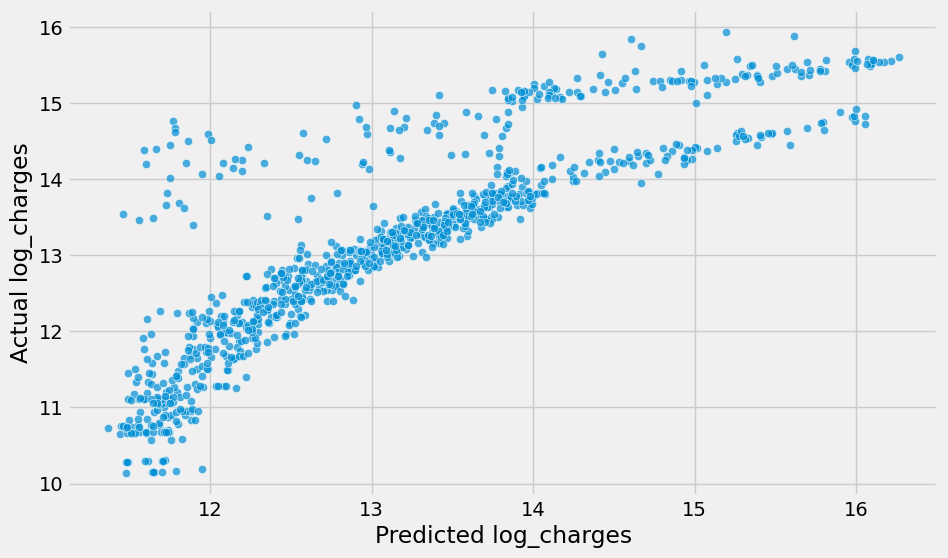

In [95]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'is_smoker': X_train['is_smoker'],
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual',
                data=plot_df, alpha=0.7)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

The residual plot reveals a clear curvature rather than a random scatter around the diagonal, indicating that the linear model may not fully capture the underlying relationship. Despite a reasonable R² score, this pattern suggests systematic over- and under-predictions, pointing to potential non-linearity in the data that the current model fails to address.



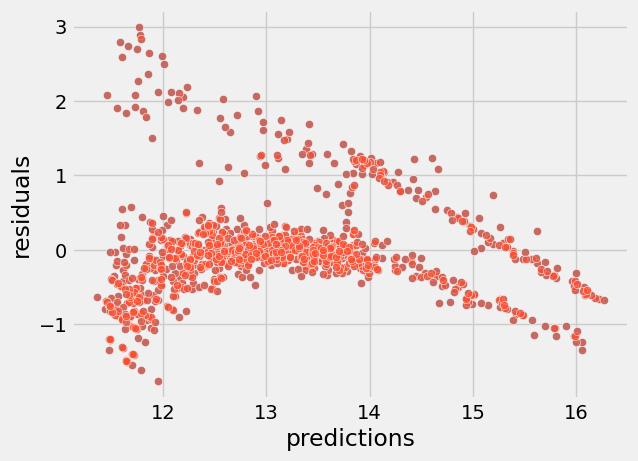

In [97]:
sns.scatterplot(x='predictions', y='residuals',
                data=plot_df, alpha=0.7)
plt.show()

The residual plot reveals a downward trend as predicted values increase, indicating a potential violation of the linear regression assumptions. Ideally, residuals should be randomly scattered around zero, but here they show a pattern, suggesting non-constant variance (heteroscedasticity). While this doesn’t render the model unusable, it raises concerns about the validity of its assumptions and highlights areas for potential improvement.

**Interpreting the Model**

In [99]:
cdf = pd.DataFrame(insurance_model.coef_, X.columns, columns=['Coef'])
print(cdf)

               Coef
age        0.050862
bmi        0.015637
is_smoker  2.232148


In [100]:
insurance_model.intercept_

np.float64(10.199942936238687)

The linear regression equation is: $$
\text{log\_charges} = 10.200 + 0.051 \times \text{age} + 0.016 \times \text{bmi} + 2.232 \times \text{is\_smoker}
$$


The smoker coefficient (2.232) stands out as the most influential predictor in the model. Since the model is in log scale, this implies that being a smoker increases expected insurance charges by approximately $2^{2.232} \approx 4.7$ times. This substantial impact likely explains the distinct separation observed in predicted values across smoker and non-smoker groups.



**Final Model Evaluation**

In [101]:
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4529281560931768

In [102]:
# Putting the outcome (in log-terms) back into the original scale
np.exp2(mean_squared_error(y_test, test_pred))

np.float64(1.3688156465634753)

While the MSE appears low, residual analysis revealed notable violations of linear regression assumptions, suggesting the model may not generalize well. 

**Segmenting by Smoker Status**

In [105]:
smokers_df = df[df["is_smoker"] == True]
X = smokers_df[["age", "bmi"]]
y = smokers_df["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)
smoker_model = LinearRegression()
smoker_model.fit(X_train, y_train)
smoker_model.coef_

array([0.01282851, 0.07098738])

In [106]:
y_pred = smoker_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.07046354357369702

In [107]:
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7661650418251629

The change in coefficients confirms that the relationship between predictors and insurance costs differs significantly for smokers. Age becomes a less important factor (dropping from 0.051 to 0.013), while BMI has a stronger influence (rising from 0.016 to 0.071). The substantial drop in MSE from 0.448 to 0.070 further supports the idea that smokers and non-smokers follow distinct cost patterns. This shows that building separate models for different groups can improve accuracy without added complexity.

Checking if the actual vs. predicted values and residuals show improvement.

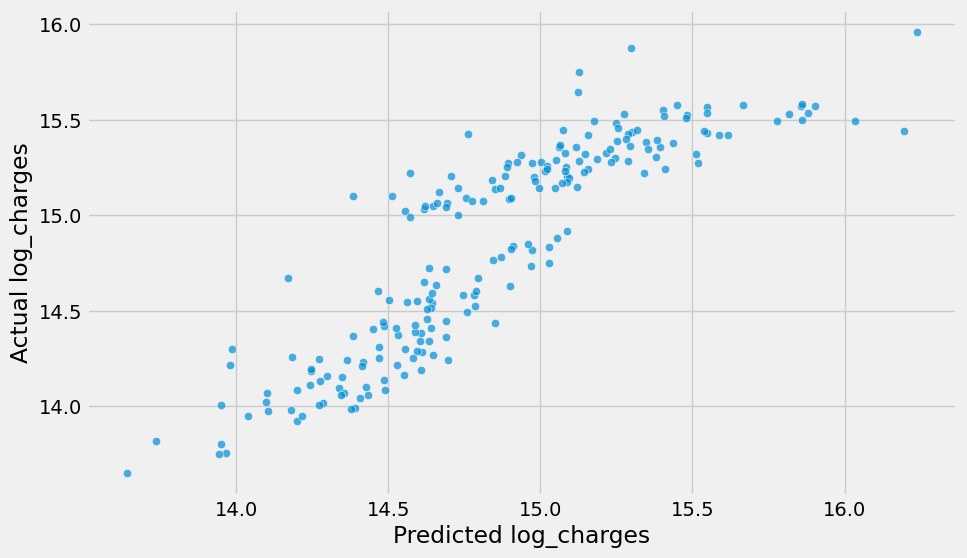

In [108]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual',
                data=plot_df, alpha=0.7)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

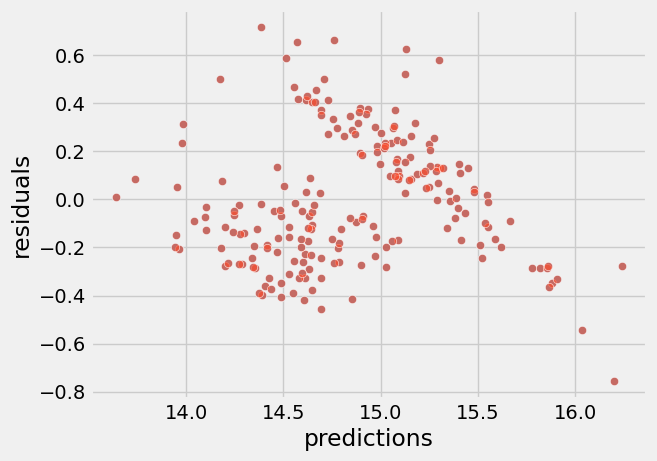

In [110]:
sns.scatterplot(x='predictions', y='residuals',
                data=plot_df, alpha=0.7)
plt.show()

Although the residual pattern is not entirely random, it shows a substantial improvement over the original model, indicating better alignment with linear regression assumptions.

In [111]:
test_pred = smoker_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.09416078156173806

In [113]:
# Filter the dataset for non-smokers


nonsmokers_df = df[df["is_smoker"] == False]

# Define predictors and target
X = nonsmokers_df[["age", "bmi"]]
y = nonsmokers_df["log_charges"]

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# Fit the model
nonsmoker_model = LinearRegression()
nonsmoker_model.fit(X_train, y_train)

# Coefficients
print("Coefficients:", nonsmoker_model.coef_)

# Predictions and metrics
y_pred = nonsmoker_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred)
train_r2 = r2_score(y_train, y_pred)

print("Train MSE:", train_mse)
print("Train R²:", train_r2)


Coefficients: [0.06025748 0.00083512]
Train MSE: 0.43205517821573175
Train R²: 0.6240935010834165


The coefficients for the non-smoker model show a very different relationship between predictors and insurance costs compared to the smoker model:

Age coefficient increased from 0.013 (in smokers) to 0.060, suggesting age is far more influential in predicting costs for non-smokers.

BMI coefficient dropped from 0.071 (in smokers) to 0.0008, indicating BMI has minimal impact on non-smoker charges.

While the train MSE of 0.432 is higher than the smoker model’s 0.070, this is expected—non-smoker charges have lower values and subtler variation.
The R² score of 0.62 shows the model still explains a good portion of the variance.

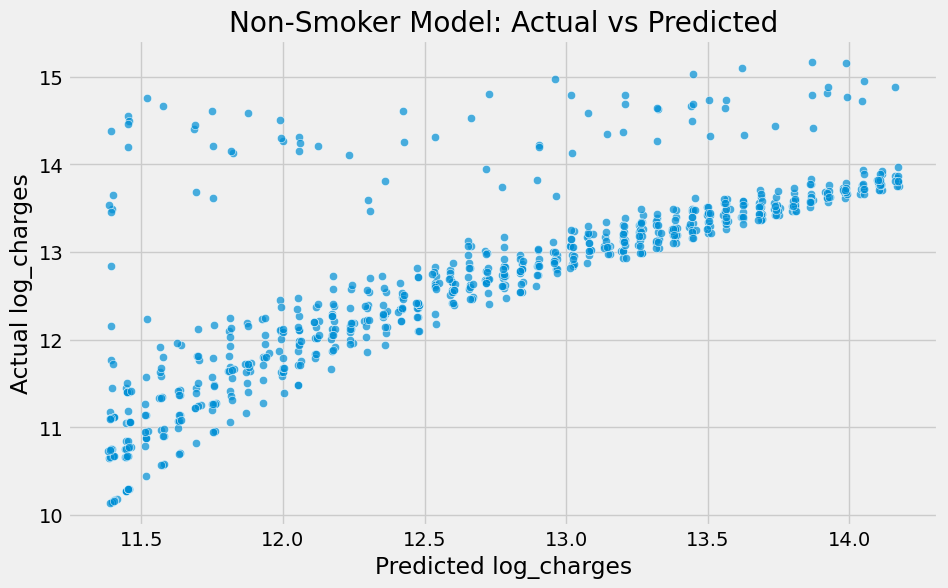

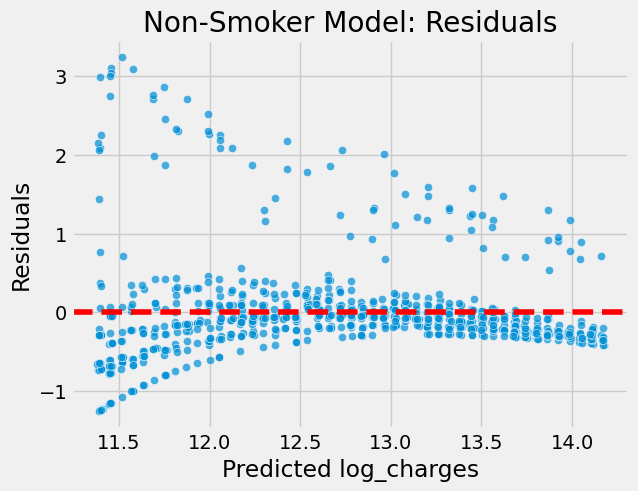

In [114]:
# DataFrame for plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', data=plot_df, alpha=0.7)
plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')
plt.title('Non-Smoker Model: Actual vs Predicted')
plt.show()

# Residuals
sns.scatterplot(x='predictions', y='residuals', data=plot_df, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log_charges')
plt.ylabel('Residuals')
plt.title('Non-Smoker Model: Residuals')
plt.show()


**Actual vs. Predicted Plot**

Points generally follow a diagonal trend, indicating a reasonable overall fit.

However, the vertical spread increases at higher predicted values, suggesting greater variance in actual charges.

**Residuals Plot**

Residuals are not randomly scattered around zero; there's a clear funnel pattern, indicating heteroscedasticity.

Underestimation of higher charges is visible residuals tend to be positive at lower predicted values and negative at higher ones.

This pattern violates regression assumptions and suggests that the model may be missing key predictors or non linear relationships.



**$\Large\text{Conclusion}$**


1.Smoking status is the most significant predictor of insurance charges

2.Relationships between predictors (age, BMI) and charges differ substantially between smokers and non-smokers

3.Building separate models improves accuracy (especially for smokers) and provides better insights into different cost structures.

